<a href="https://colab.research.google.com/github/formroller/ML_clone/blob/master/kaggle/Santander/SantanderPredcition6(SMOTE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SantanderPrediction을 수행하며 target값이 불균형한 것을 확인했으며 이를 해결하기 위해 SMOTE기법을 사용해 target 변수의 수치 조절한 후 예측을 수행하겠다.

# 1.Load Package

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
os.chdir('/content/drive/MyDrive/kaggle/Santander')

import gc
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import *

warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

Class 0 : 179902
Class 1 : 20098
Proportion : 8.95 : 1


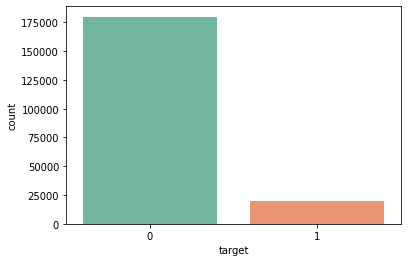

In [4]:
sns.countplot(train['target'], palette='Set2')

target_count = train.target.value_counts()
print(f"Class 0 : {target_count[0]}")
print(f"Class 1 : {target_count[1]}")
print(f"Proportion : {round(target_count[0]/target_count[1],2)} : 1")

# 2.Featrue Engineering

## 2.1 Imbalance Data(SMOTE)

In [5]:
train.drop(['ID_code'],axis=1, inplace=True)
test.drop(['ID_code'], axis=1, inplace=True)

In [6]:
sm = SMOTE(random_state=43)

X = train.drop(['target'], axis=1)
y = train['target']

x_sm, y_sm = sm.fit_resample(X, y)

In [7]:
target = pd.DataFrame({'target':y_sm})
features = pd.DataFrame(x_sm, columns=X.columns)
train_sm = pd.concat([target, features],axis=1)

## 2.2 Aggregation


In [8]:
idx = features = train_sm.columns.values[1:201]
for df in [test, train_sm]:
    df['sum'] = df[idx].sum(axis=1)
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurt(axis=1)
    df['med'] = df[idx].median(axis=1)

In [9]:
train_sm[train_sm.columns[201:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1456.3182,-21.4494,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
3,1288.2319,-35.1659,38.1015,6.441159,9.594064,-0.480116,2.630499,6.70260
4,1354.2310,-65.4863,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735


In [10]:
test[test.columns[201:]].head()

,min,max,mean,std,skew,kurt,med
0,-31.9891,42.0248,7.083202,9.910632,-0.088518,1.871262,7.31440
1,-41.1924,35.6020,6.248430,9.541267,-0.559785,3.391068,6.43960
2,-34.3488,39.3654,7.151299,9.967466,-0.135084,2.326901,7.26355
3,-21.4797,40.3383,7.057223,8.257204,-0.167741,2.253054,6.89675
4,-24.8254,45.5510,7.118682,10.043542,0.293484,2.044943,6.83375


# 3.Model

## 3.1 feature, target split

In [11]:
features = train_sm.drop(['target'], axis=1)
target = train_sm['target']

## 3.2 모델 하이퍼파리미터 정의

In [12]:
param = {
    'bagging_freq':5, 
    'bagging_fraction':0.4,
    'boost_from_average':'false',
    'boost':'gbdt',
    'feature_fractions':0.05,
    'learning_rate':0.01,
    'max_depth':-1,
    'metric':'auc',
    'min_data_in_leaf':80,
    'min_sum_hessian_in_leaf':10.0,
    'num_leaves':13,
    'num_threads':8,
    'tree_learner':'serial',
    'objective':'binary',
    'verbosity':1
}

## 3.3 모델링

In [13]:
# # Fold = 5, num_round = 100000

# folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=44000)
# oof = np.zeros(len(train_sm))
# predictions = np.zeros(len(test))
# feature_importance_df = pd.DataFrame()

# for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_sm.values, target.values)):
#     print(f"Fold {fold_}")
#     trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
#     val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

#     num_round = 100000 #1000000
#     clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data], verbose_eval=1000, early_stopping_rounds=3000)
#     oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration = clf.best_iteration)

#     fold_importance_df = pd.DataFrame()
#     fold_importance_df['Feature'] = features
#     fold_importance_df['Importacne'] = clf.feature_importance()
#     fold_importance_df['fold'] = fold_ + i
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
#     predictions += clf.predict(test[features], num_iteration=clf.best_iteration)/folds.n_splits

# print('CV score : {:<8.5}'.format(roc_auc_score(target, oof)))

# # https://www.kaggle.com/ayushikaushik/eda-oversampling-classification#Logistic-Regression 참조

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=123)
kfold = StratifiedKFold(n_splits=10, shuffle=True)

cross_val_score(rf, features, target, cv = kfold, scoring = 'accuracy')

array([0.9635641 , 0.96328618, 0.96520386, 0.96217448, 0.96236798,
       0.96181212, 0.96206226, 0.96183991, 0.96206226, 0.96222902])

In [18]:
rf.fit(features, target)


RandomForestClassifier(random_state=123)

In [19]:
rf.predict(test)

array([0, 0, 0, ..., 0, 0, 0])

> [(kaggle)Santander 불균형 데이터](https://www.kaggle.com/vaishnavinath/before-and-after-smote/notebook)  
> [불균형 데이터](https://shinminyong.tistory.com/34)  
> [불균형 데이터 처리](https://dacon.io/codeshare/3699?dtype=recent)